# Code: U21EC019

## LSTM

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [ ]:
# Force TensorFlow to use CPU
os.environ["CUDA_VISIBLE_DEVICES"] 

In [79]:
# Load and preprocess the data
data = pd.read_csv('airline-passengers.csv', index_col='Month', parse_dates=True)
data.index.freq = 'MS'  # Set the frequency to start of the month for monthly data
data

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [80]:
# Scale data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Passengers']].values.astype('float32'))

In [81]:
# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length, 0])
    return np.array(x), np.array(y)

In [82]:
# Sequence length for time series data
sequence_length = 15  # Increased sequence length for better temporal learning
x, y = create_sequences(scaled_data, sequence_length)

# Reshape input data for LSTM (samples, timesteps, features)
x = x.reshape((x.shape[0], x.shape[1], 1))

In [83]:
# Build the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, 1), 
         activation='tanh', recurrent_activation='sigmoid', use_bias=True, unroll=True),
    Dropout(0.2),
    LSTM(64, activation='tanh', recurrent_activation='sigmoid', use_bias=True, unroll=True),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [84]:
# Train the model on the entire dataset
history = model.fit(x, y, epochs=70, batch_size=32, verbose=2) 

Epoch 1/70
5/5 - 6s - loss: 0.1587 - 6s/epoch - 1s/step
Epoch 2/70
5/5 - 0s - loss: 0.0565 - 222ms/epoch - 44ms/step
Epoch 3/70
5/5 - 0s - loss: 0.0201 - 226ms/epoch - 45ms/step
Epoch 4/70
5/5 - 0s - loss: 0.0177 - 283ms/epoch - 57ms/step
Epoch 5/70
5/5 - 0s - loss: 0.0175 - 288ms/epoch - 58ms/step
Epoch 6/70
5/5 - 0s - loss: 0.0181 - 215ms/epoch - 43ms/step
Epoch 7/70
5/5 - 0s - loss: 0.0151 - 225ms/epoch - 45ms/step
Epoch 8/70
5/5 - 0s - loss: 0.0114 - 225ms/epoch - 45ms/step
Epoch 9/70
5/5 - 0s - loss: 0.0108 - 259ms/epoch - 52ms/step
Epoch 10/70
5/5 - 0s - loss: 0.0146 - 257ms/epoch - 51ms/step
Epoch 11/70
5/5 - 0s - loss: 0.0139 - 251ms/epoch - 50ms/step
Epoch 12/70
5/5 - 0s - loss: 0.0141 - 426ms/epoch - 85ms/step
Epoch 13/70
5/5 - 0s - loss: 0.0140 - 297ms/epoch - 59ms/step
Epoch 14/70
5/5 - 0s - loss: 0.0150 - 220ms/epoch - 44ms/step
Epoch 15/70
5/5 - 0s - loss: 0.0147 - 233ms/epoch - 47ms/step
Epoch 16/70
5/5 - 0s - loss: 0.0119 - 260ms/epoch - 52ms/step
Epoch 17/70
5/5 - 0s -

In [85]:
# Make predictions on the entire dataset
predictions = model.predict(x)

# Inverse transform the predictions and actual values to get the original scale
predictions = scaler.inverse_transform(predictions)
y_rescaled = scaler.inverse_transform(y.reshape(-1, 1))

5/5 [==============================] - 1s 10ms/step


In [86]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_rescaled, predictions)
mse = mean_squared_error(y_rescaled, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 35.15242004394531
Mean Squared Error (MSE): 2687.57373046875
Root Mean Squared Error (RMSE): 51.84181594848633


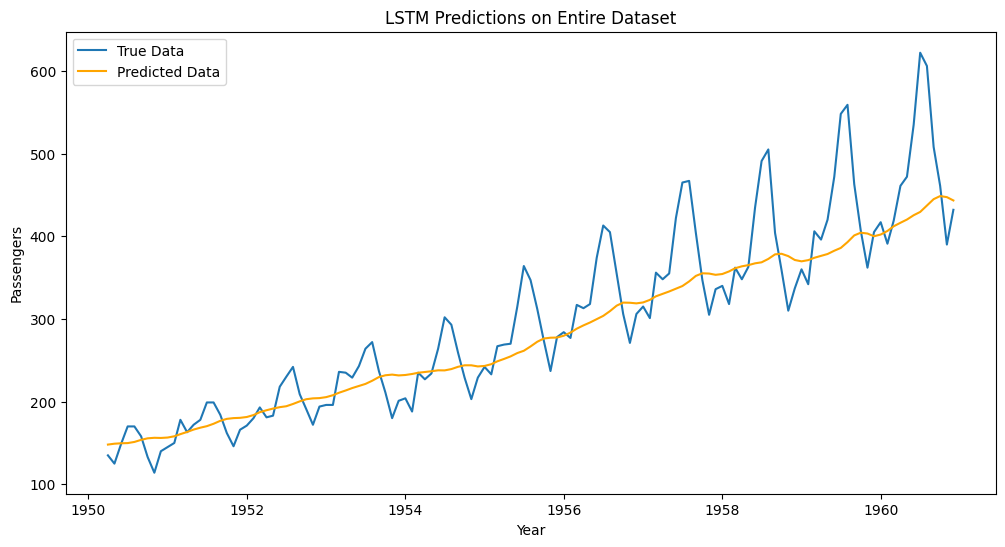

In [88]:
# Plot the predictions on the entire dataset
plt.figure(figsize=(12, 6))
plt.plot(data.index[sequence_length:], y_rescaled, label="True Data")
plt.plot(data.index[sequence_length:], predictions, label="Predicted Data", color='orange')
plt.title("LSTM Predictions on Entire Dataset")
plt.xlabel("Year")
plt.ylabel("Passengers")
plt.legend()

# Format x-axis to show years
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.show()

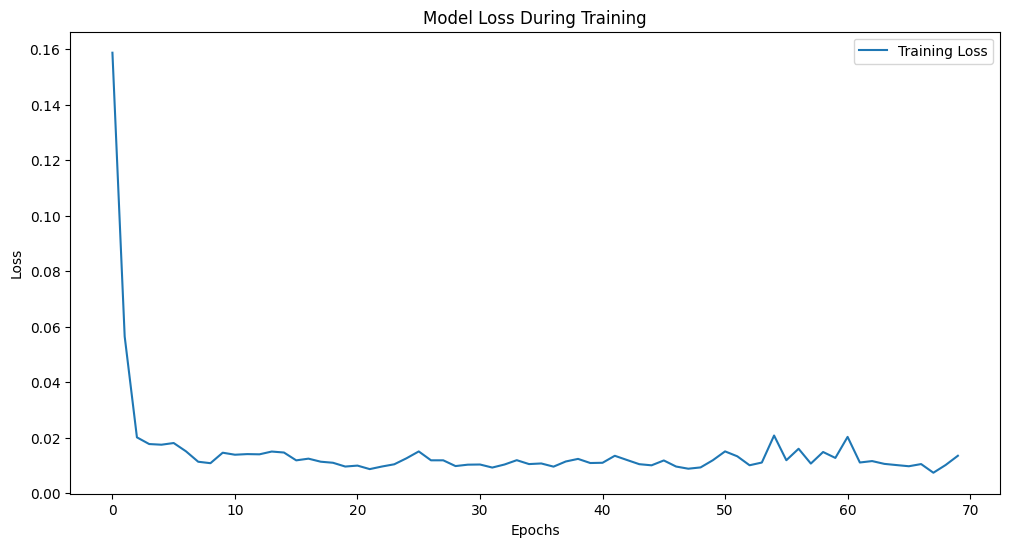

In [89]:
# Plot training loss curve
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title("Model Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()